In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import joblib

# Make sure "scripts" is in your Python path so you can import from scripts/preprocessing.py
sys.path.append('scripts')

# Import your functions and feature list
from preprocessing import preprocess, selected_features


In [9]:
def plot_roc(y_true, y_proba, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def plot_conf_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


In [4]:
# --- Data Preprocessing ---
DATA_PATH = "data/raw/HR_Attrition_Dataset.csv"

# CALL YOUR FUNCTION (assumes returns train/val/test splits in same order as before)
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(data_path=DATA_PATH)


In [5]:
# --- Set up StratifiedKFold and Hyperparameter Grid
n_splits = 5

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=skf,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
best_logreg = grid_search.best_estimator_



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [6]:
# --- Get Cross-Validation Results ---
cv_results = pd.DataFrame(grid_search.cv_results_)
leaderboard = cv_results.loc[:, ['params', 'mean_test_score', 'std_test_score']]
leaderboard = leaderboard.rename(columns={'mean_test_score': 'mean_ROC_AUC', 'std_test_score': 'std_ROC_AUC'})
leaderboard = leaderboard.sort_values(by="mean_ROC_AUC", ascending=False)
print(leaderboard.head())

                                              params  mean_ROC_AUC  \
3  {'C': 0.1, 'penalty': 'l2', 'solver': 'libline...      0.812200   
4       {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}      0.811597   
2     {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}      0.810943   
5   {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}      0.810856   
7  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}      0.810328   

   std_ROC_AUC  
3     0.028947  
4     0.019550  
2     0.024104  
5     0.020756  
7     0.019469  


In [7]:
# --- Evaluate Best Model on Validation Set ---
y_pred_val = best_logreg.predict(X_val)
y_proba_val = best_logreg.predict_proba(X_val)[:, 1]

val_metrics = {
    'accuracy': accuracy_score(y_val, y_pred_val),
    'precision': precision_score(y_val, y_pred_val),
    'recall': recall_score(y_val, y_pred_val),
    'f1': f1_score(y_val, y_pred_val),
    'roc_auc': roc_auc_score(y_val, y_proba_val),
    'confusion_matrix': confusion_matrix(y_val, y_pred_val).tolist()
}
print("Validation Metrics:", val_metrics)



Validation Metrics: {'accuracy': 0.7959183673469388, 'precision': 0.41975308641975306, 'recall': 0.723404255319149, 'f1': 0.53125, 'roc_auc': np.float64(0.8272030321302438), 'confusion_matrix': [[200, 47], [13, 34]]}


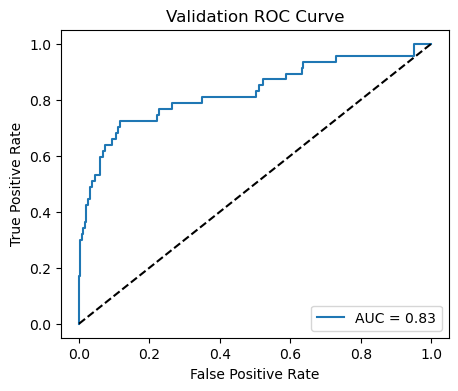

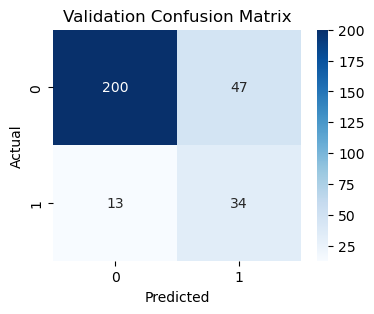

In [10]:
# ROC curve for validation
plot_roc(y_val, y_proba_val, 'Validation ROC Curve')

# Confusion matrix for validation
plot_conf_matrix(y_val, y_pred_val, 'Validation Confusion Matrix')


In [11]:
# --- Evaluate Best Model on Test Set ---

y_test_pred = best_logreg.predict(X_test)
y_test_proba = best_logreg.predict_proba(X_test)[:, 1]

test_metrics = {
    'accuracy': accuracy_score(y_test, y_test_pred),
    'precision': precision_score(y_test, y_test_pred),
    'recall': recall_score(y_test, y_test_pred),
    'f1': f1_score(y_test, y_test_pred),
    'roc_auc': roc_auc_score(y_test, y_test_proba),
    'confusion_matrix': confusion_matrix(y_test, y_test_pred).tolist()
}
print("Test Set Metrics:", test_metrics)


Test Set Metrics: {'accuracy': 0.7653061224489796, 'precision': 0.37209302325581395, 'recall': 0.6808510638297872, 'f1': 0.48120300751879697, 'roc_auc': np.float64(0.8041174950469463), 'confusion_matrix': [[193, 54], [15, 32]]}


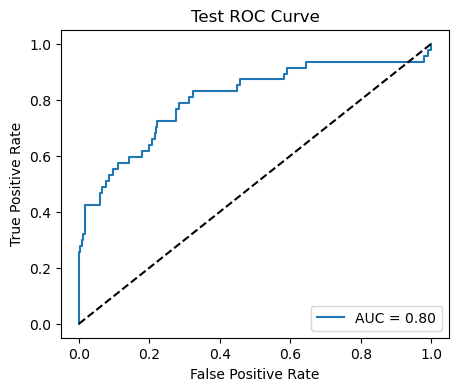

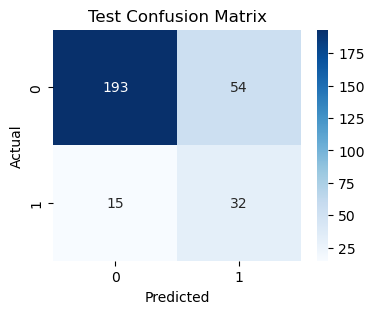

In [12]:
# ROC curve for test set
plot_roc(y_test, y_test_proba, 'Test ROC Curve')

# Confusion matrix for test set
plot_conf_matrix(y_test, y_test_pred, 'Test Confusion Matrix')


In [ ]:
MODEL_PATH = 'models'
os.makedirs(MODEL_PATH, exist_ok=True)
model_filename = os.path.join(MODEL_PATH, 'logistic_regression_best.pkl')
joblib.dump(best_logreg, model_filename)
print(f"Model saved to {model_filename}")


In [ ]:
# Validation run logging
log_file_val = "logs/logreg_runs.json"
log_experiment(
    log_file=log_file_val,
    model_name="Logistic Regression (Validation)",
    variables=selected_features,
    params=grid_search.best_params_,
    metrics=val_metrics
)
print(f"Validation run logged to {log_file_val}")

# Test run logging
log_file_test = "logs/logreg_test_runs.json"
log_experiment(
    log_file=log_file_test,
    model_name="Logistic Regression (Test)",
    variables=selected_features,
    params=grid_search.best_params_,
    metrics=test_metrics
)
print(f"Test run logged to {log_file_test}")
